From: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb

In [ ]:
%pip install monai

In [2]:
import numpy as np
import os
import monai
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from monai.data import DataLoader,pad_list_data_collate,Dataset
from monai.transforms import Compose,LoadImaged,EnsureChannelFirstd,Transposed,RandSpatialCropd,ToTensord

In [3]:
def load_images(directory_pelvis: str, device=None):
    """
    Load MRI and CT images, preprocess them, and return preprocessed pairs on the specified device.

    Args:
        directory_pelvis (str): Path to the dataset directory.
        device (torch.device): Device to which the tensors will be moved (e.g., 'cuda' or 'cpu').

    Returns:
        list: A list of dictionaries containing preprocessed 'mr' and 'ct' images.
    """
    
    # Default to CPU if no device is specified
    if device is None:
        device = torch.device("cpu")

    dataset = []
    
    for folder_patient in os.listdir(directory_pelvis):
        patient_path = os.path.join(directory_pelvis, folder_patient)
        #print(patient_path)

        # Load MRI and CT images for each patient
        mri_processed_path = os.path.join(patient_path, "mr_processed.nii.gz") 
        ct_processed_path = os.path.join(patient_path, "ct_processed.nii.gz")

        if os.path.exists(mri_processed_path) and os.path.exists(ct_processed_path):
            dataset.append({"mr": mri_processed_path,"ct": ct_processed_path})

    transforms = Compose([
        LoadImaged(keys=["mr", "ct"]),
        EnsureChannelFirstd(keys=["mr", "ct"]),
        # Permute dimensions of tensors to match the desired order
        # [C, D, W, H]->[C, H, W, D]
        Transposed(keys=["mr", "ct"], indices=(0, 3, 2, 1)),
        RandSpatialCropd(keys=["mr", "ct"], roi_size=(240, 240, 20), random_size=False), # Random Crop
        ToTensord(keys=["mr", "ct"])
    ])  

    monai_dataset = Dataset(data=dataset, transform=transforms)
    train_dataset, val_dataset = torch.utils.data.random_split(monai_dataset, [0.8, 0.2])
    
    train_dl = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate) # to handle tensors of different sizes
    val_dl = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate)
    
    return train_dataset,val_dataset, train_dl, val_dl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset,val_dataset, train_dl, val_dl = load_images("C:\\Users\\catar\\OneDrive - Universidade de Coimbra\\Ambiente de Trabalho\\Master Thesis\\Code\\mythesisprojects\\processed_data", device=device)


In [4]:
for real_images in train_dataset:
    print("MR:",real_images['mr'].shape)
    print("CT:",real_images['ct'].shape)
    
for real_images in train_dl:
    print("MR:",real_images['mr'].shape)
    print("CT:",real_images['ct'].shape)
    
for real_images in val_dl:
    print("MR:",real_images['mr'].shape)
    print("CT:",real_images['ct'].shape)

MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 240, 240, 20])
CT: torch.Size([1, 240, 240, 20])
MR: torch.Size([1, 1, 240, 240, 20])
CT: torch.Size([1, 1, 240, 240, 20])
MR: torch.Size([1, 1, 240, 240, 20])
CT: torch.Size([1, 1, 240, 240, 20])
MR: torch.Size([1, 1, 240, 240, 20])
CT: torch.Size([1, 1, 240, 240, 20])
MR: torch.Size([1, 1, 240, 240, 20])
CT: torch.Size([1, 1, 240, 240, 20])
MR: torch.Size([1, 1, 240, 240, 20])
CT: torch.Size([1, 1, 240, 240, 20])
MR: torch.Size([1, 1, 240, 240, 20])
CT: torch.Size([1, 1, 240, 240, 20])
MR: torch.Si

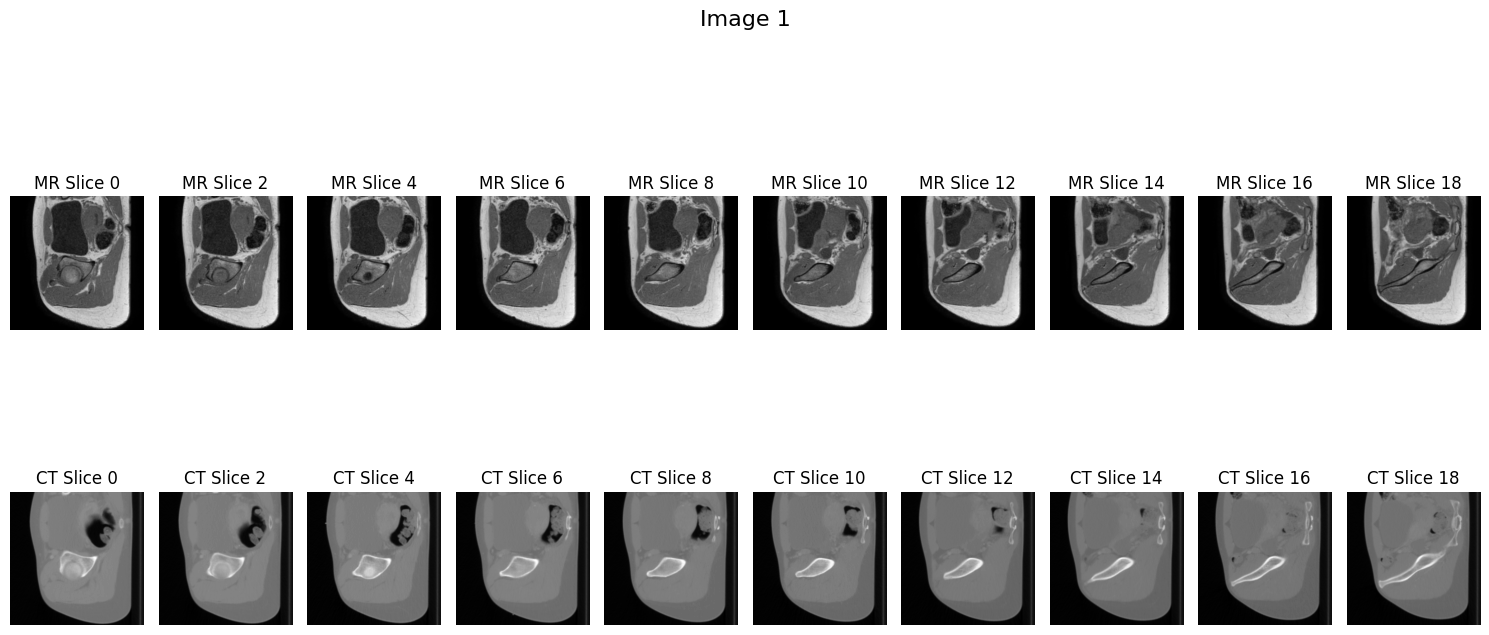

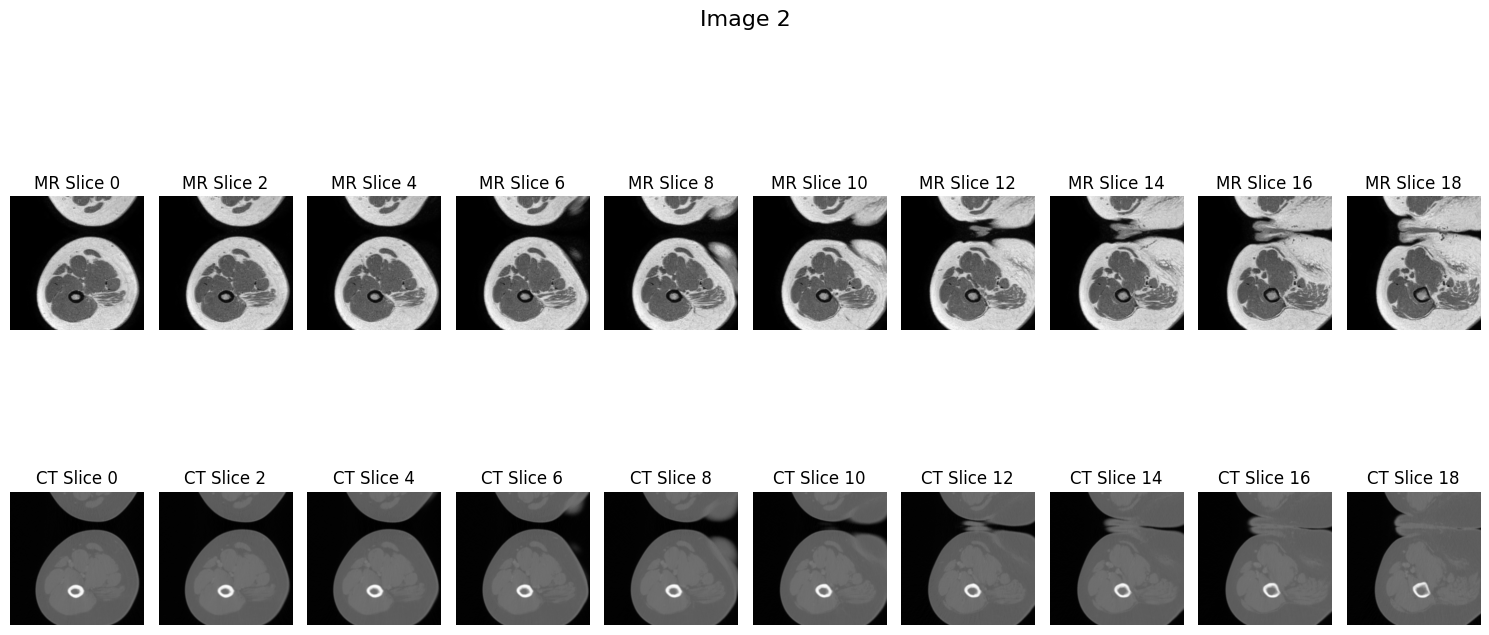

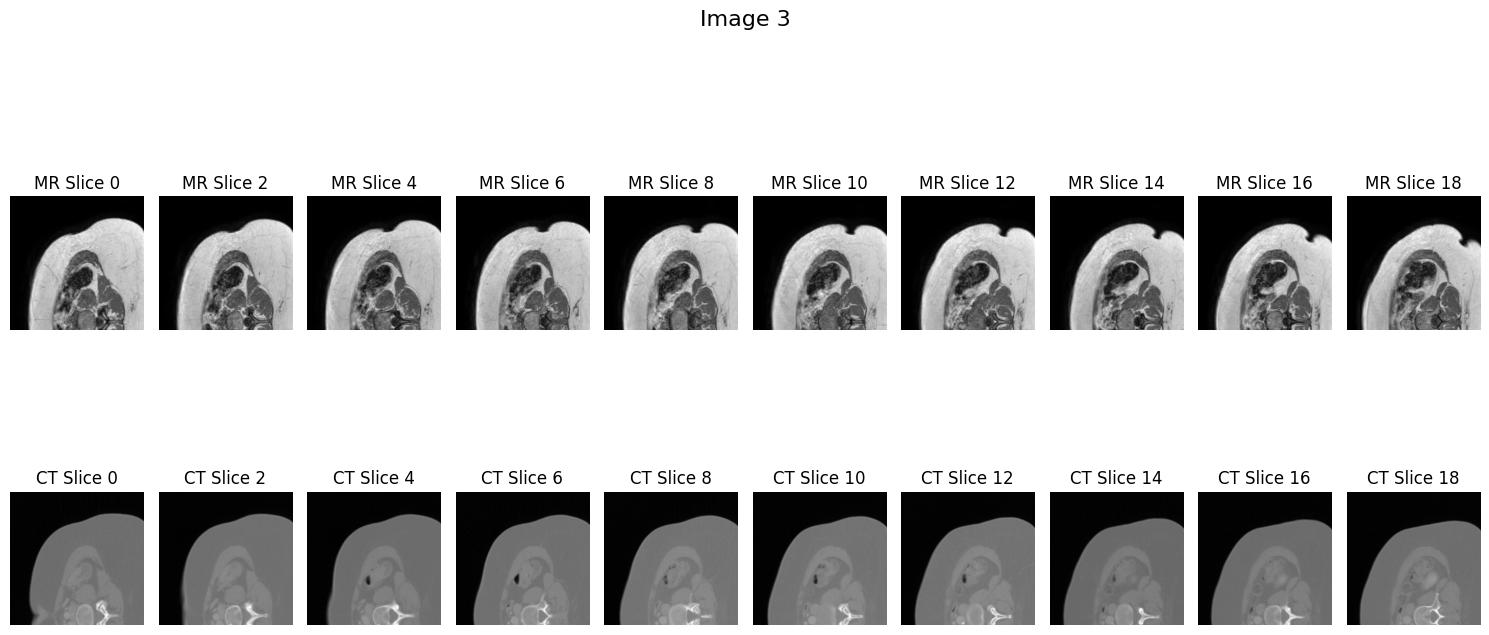

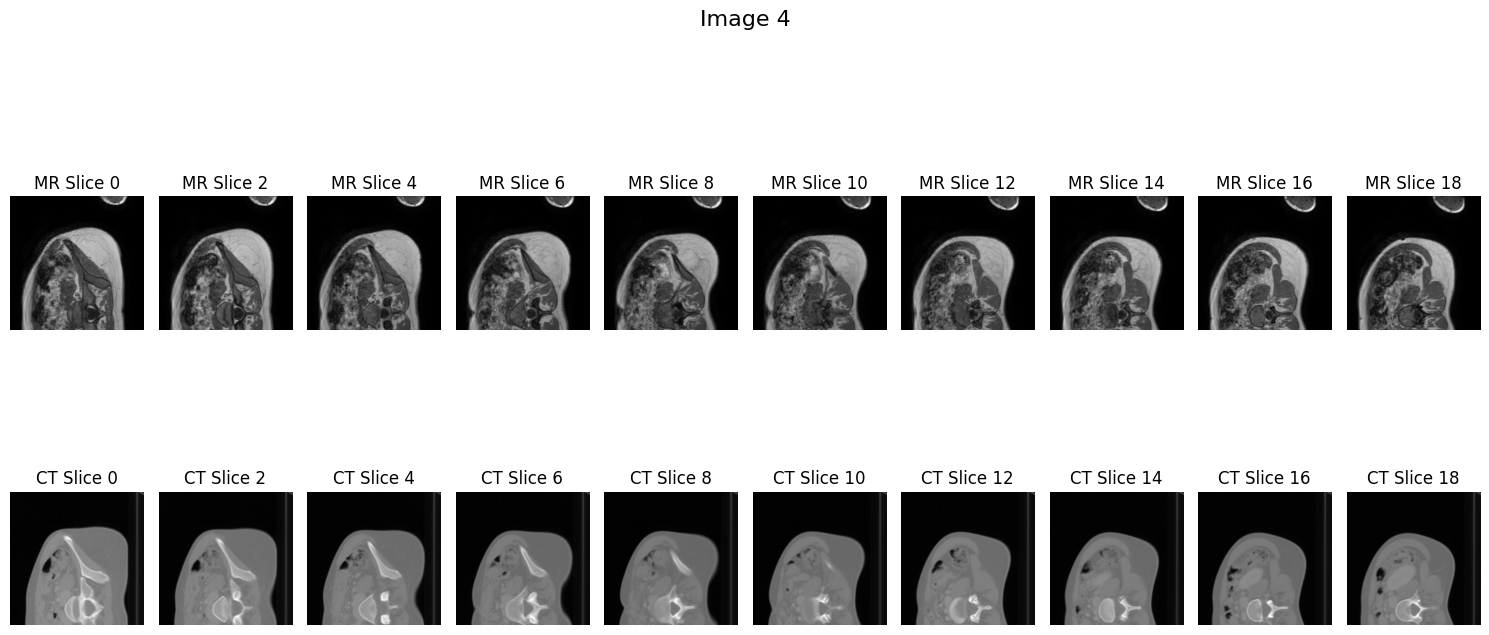

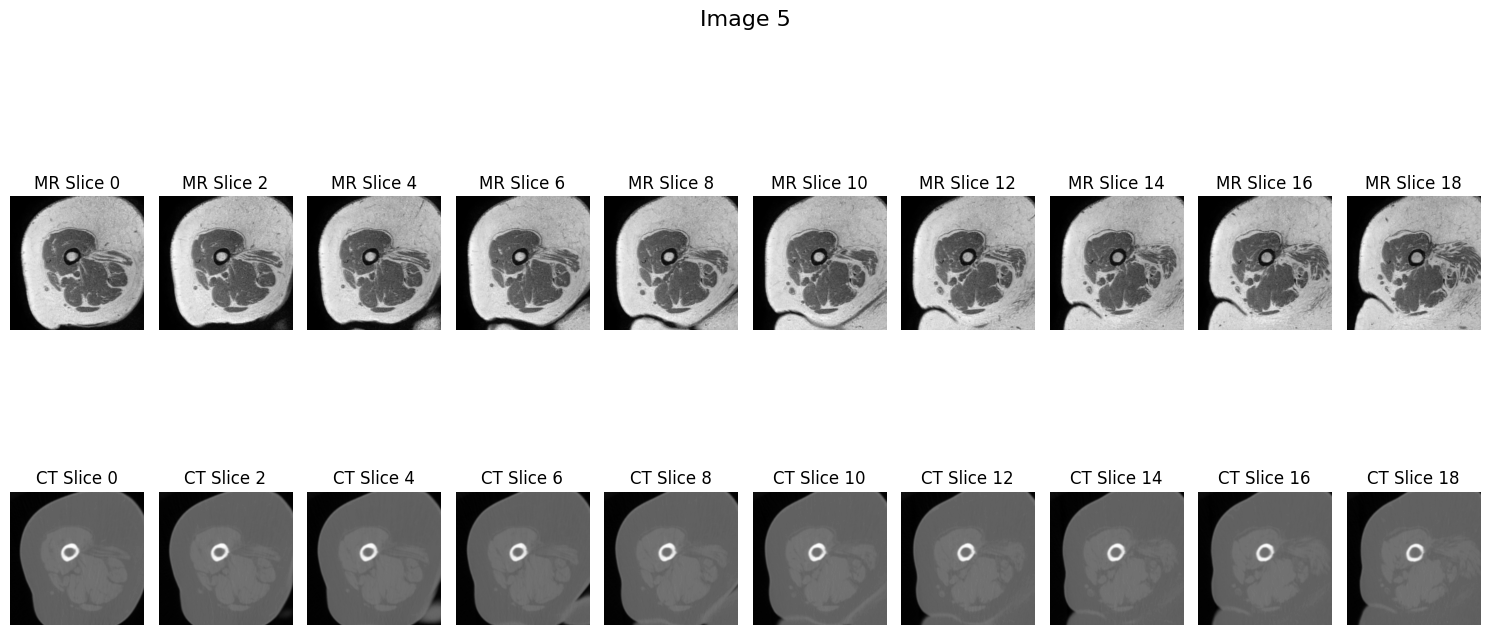

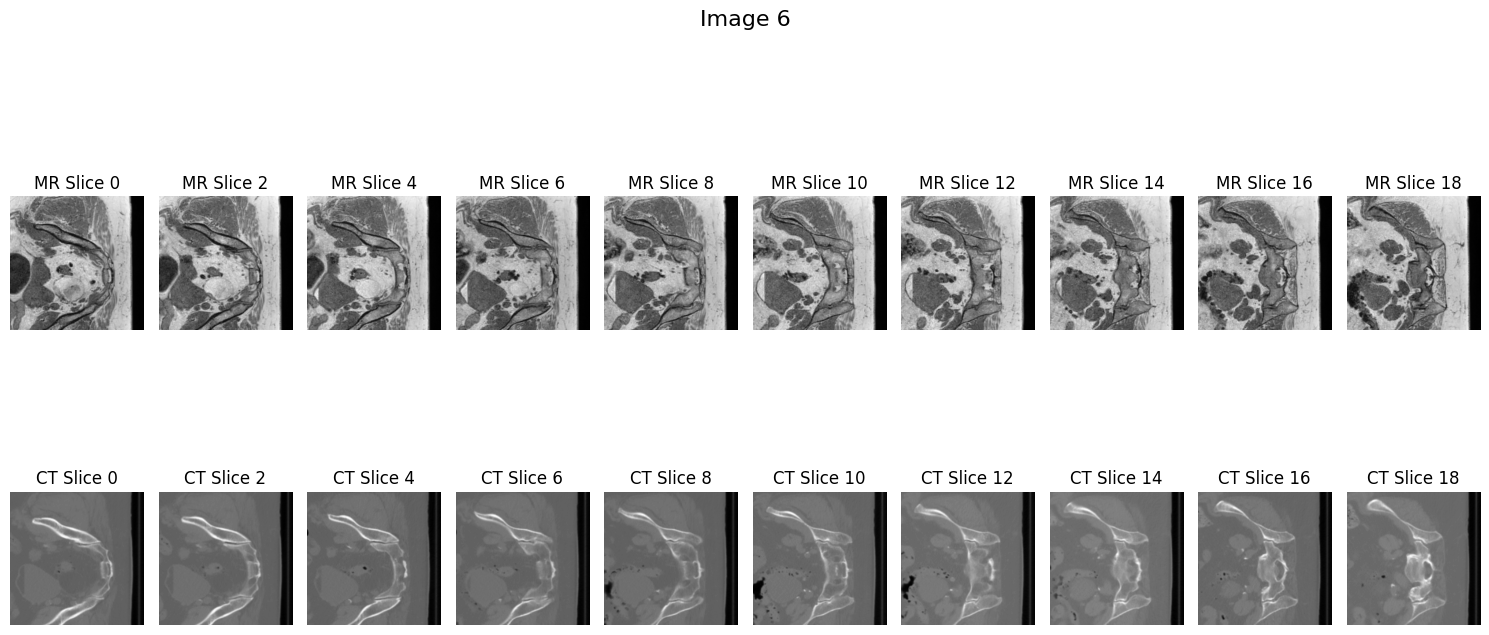

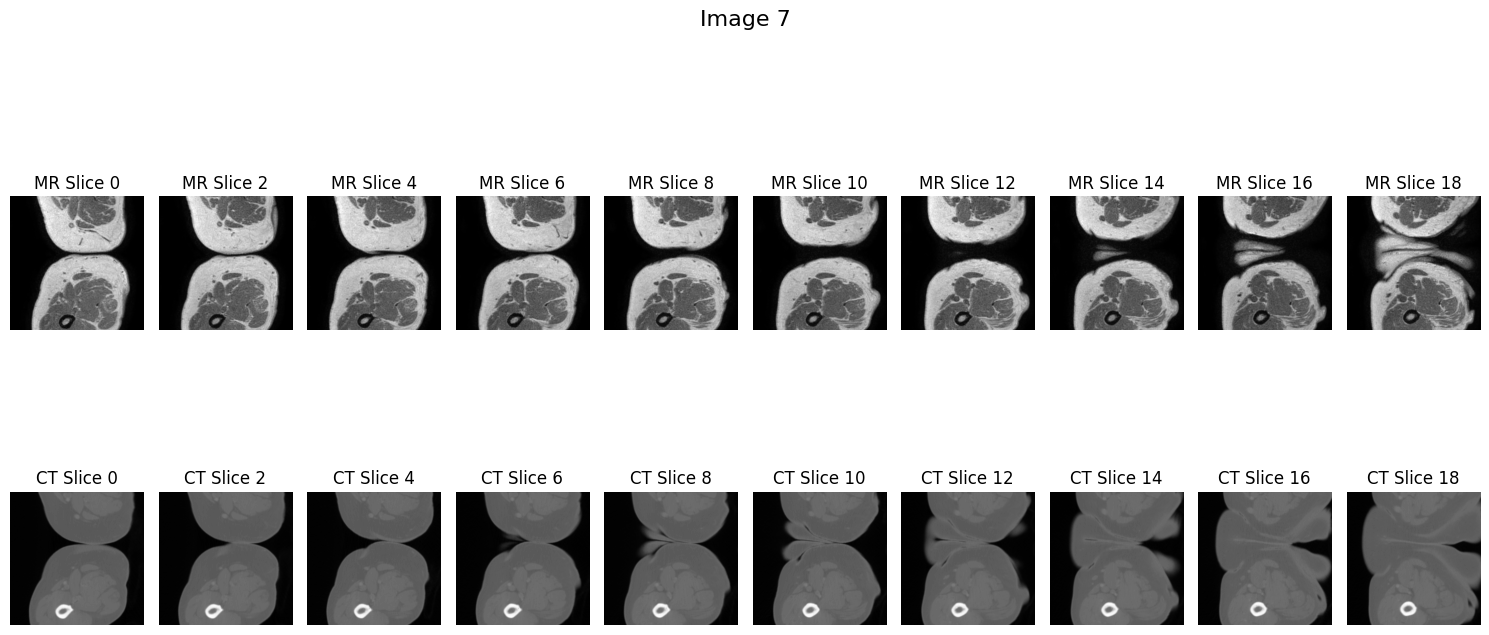

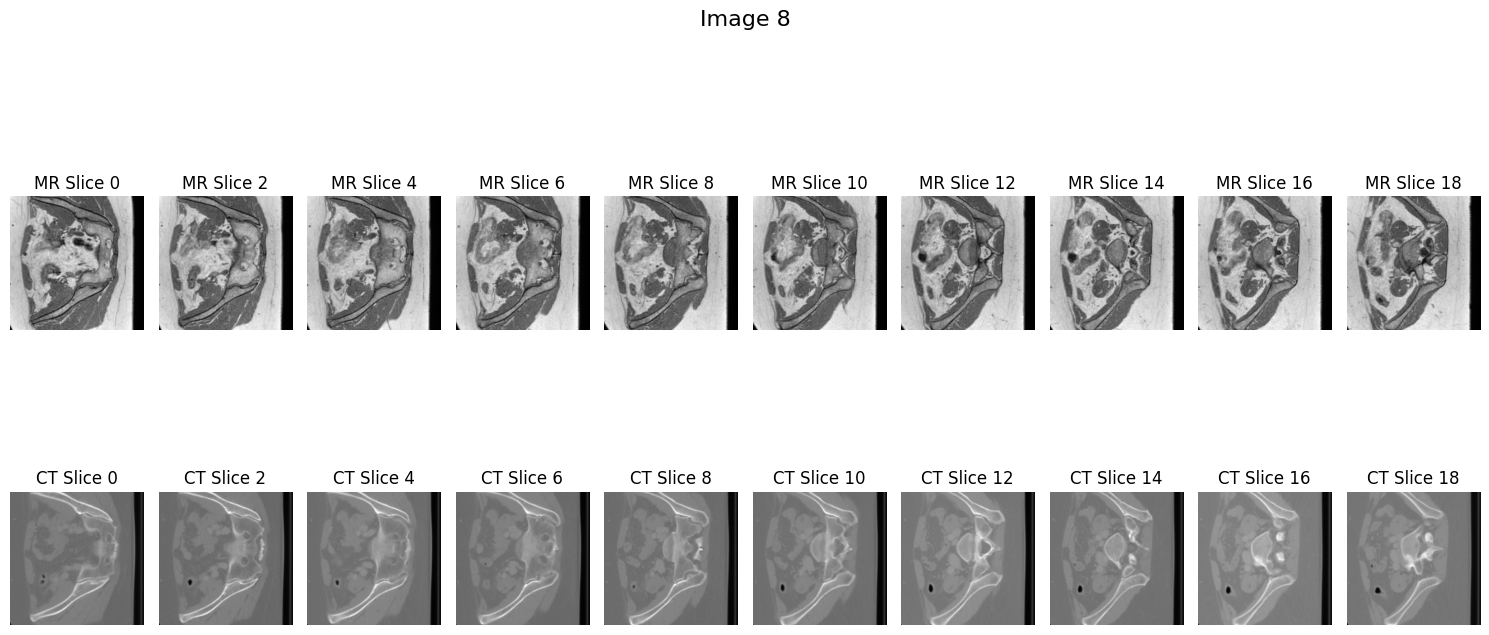

In [5]:
def visualize_batch(train_dl, num_slices=5):
    """
    Visualize MRI and CT images from the DataLoader.

    Args:
        train_dl (DataLoader): DataLoader containing processed batches.
        num_slices (int): Number of slices to visualize per image.
    """
    for item_idx, item in enumerate(train_dl):
        
        mr_item = item["mr"]  # Shape: [B, C, H, W, D]
        ct_item = item["ct"]  # Shape: [B, C, H, W, D]
        
        mr_image = mr_item[0, 0, :, :, :].cpu().numpy()  # Remove batch and channel dimension [H, W, D]
        ct_image = ct_item[0, 0, :, :, :].cpu().numpy()
            
        fig, axes = plt.subplots(2, num_slices, figsize=(15, 8))
        fig.suptitle(f"Image {item_idx + 1}", fontsize=16)
            
        slice_positions = [i * (mr_image.shape[2] // num_slices) for i in range(num_slices)]
            
        # Slices of MRI
        for col_idx, slice_idx in enumerate(slice_positions):
            axes[0, col_idx].imshow(mr_image[:, :, slice_idx], cmap='gray')
            axes[0, col_idx].set_title(f'MR Slice {slice_idx}')
            axes[0, col_idx].axis('off')
            
        # Slices of CT
        for col_idx, slice_idx in enumerate(slice_positions):
            axes[1, col_idx].imshow(ct_image[:, :, slice_idx], cmap='gray')
            axes[1, col_idx].set_title(f'CT Slice {slice_idx}')
            axes[1, col_idx].axis('off')
            
        axes[0, 0].set_ylabel('MRI', fontsize=12)
        axes[1, 0].set_ylabel('CT', fontsize=12)
            
        plt.tight_layout()
        plt.show()
            
visualize_batch(train_dl, num_slices=10)


(1, 1, 240, 240, 20)
(240, 240)


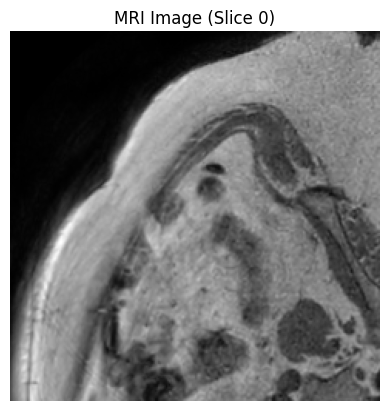

In [ ]:
dataiter = iter(train_dl)
images = next(dataiter)

mr_images = images["mr"].cpu().numpy() 
ct_images = images["ct"].cpu().numpy() 
print(mr_images.shape)

# -> [B, C, H, W, D]
img = mr_images[0,0,:,:,6] # 1st image in the batch, 1st channel, 6th slice
print(img.shape)
plt.imshow(img, cmap='gray')
plt.title("MRI Image (Slice 0)")
plt.axis('off')
plt.show()

# Adversarial Autoencoder

* ENCODER

The encoder part of the network will be a typical convolutional pyramid. 


* DECODER

The decoder needs to convert from a narrow representation to a wide, reconstructed image. The decoder portion of the network takes this lower-dimensional feature representation and upsamples it back to the original input image size using deconvolutional layers. The final output of the network is a reconstructed image that is as close as possible to the original input image.

-> Transpose convolutions:

This decoder uses transposed convolutional layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer.

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In this Distill article from Augustus Odena, et al, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer.

LeakyReLU is used as the default nonlinearity in both the encoder and the decoder as Relu kills most of the gradients. Source: https://github.com/torchgan/torchgan/blob/master/tutorials/Tutorial%205.%20Adversarial%20Autoencoder.ipynb

# Discriminator Network

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dims, nonlinearity=nn.LeakyReLU(0.2)): 
        super(Discriminator, self).__init__()
        
        model = [nn.Sequential(nn.Linear(input_dims, input_dims // 2), nonlinearity)]
        size = input_dims // 2
        while size > 16: # prevent the encoding from becoming too small
            model.append(
                nn.Sequential(
                    nn.Linear(size, size // 2), nn.LayerNorm(size // 2), nonlinearity
                )
            )
            size = size // 2
        model.append(nn.Linear(size, 1)) # transforms the 16-dimensional vector into a single scalar value (the logit)
        self.model = nn.Sequential(*model)

    def forward(self, latent):
        return self.model(latent)

In [8]:
latent_dimension = torch.randn(1, 512)  
discriminator = Discriminator(input_dims=512)
output = discriminator(latent_dimension)
print(discriminator)

print("Input latent dimension shape:", latent_dimension.shape)
print("Output shape:", output.shape)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Linear(in_features=16, out_features=1, bi

In [9]:
class AAEGenerator(nn.Module):
    # encoding_dims - size of the latent vector
    def __init__(self, encoding_dims):
        super(AAEGenerator, self).__init__() # 1, 240, 240
        self.encoding_dims = encoding_dims
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 32, 240, 240
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 64, 120, 120
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128, 60, 60
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), # 128, 30, 30
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.encoder_fc = nn.Linear(128*30*30, encoding_dims) # 128*30*30 is the size of last layer flatten 4D vector (batch,128,30,30)
        
        self.decoder_fc = nn.Linear(encoding_dims, 128*30*30)
        self.decoder = nn.Sequential( # 128, 30, 30
            nn.ConvTranspose2d(128, 64, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1), # 64, 60, 60
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 32, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1), # 32, 120, 120
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            
            nn.ConvTranspose2d(32, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1), # 1, 240, 240
            nn.Sigmoid()
        )
    
    def encoder_part(self,x):
        x = self.encoder(x)
        x = x.view(x.size(0),-1)
        encoding = self.encoder_fc(x)
        return encoding
    
    def sample(self, noise):
        noise = self.decoder_fc(noise)
        noise = noise.view(-1, 128, 30, 30)
        return self.decoder(noise)

    def forward(self, x):
        if self.training:
            encoding = self.encoder(x)
            #print(encoding.shape)
            encoding = self.encoder_fc(
                encoding.view(
                    -1, encoding.size(1) * encoding.size(2) * encoding.size(3)
                )
            )
            return self.sample(encoding), encoding
        else:
            return self.sample(x)
        


Input shape: torch.Size([1, 1, 240, 240])
Generated image shape: torch.Size([1, 1, 240, 240])
Encoding vector shape: tensor([[ 4.5600e-02,  8.3878e-01, -5.7141e-01, -4.2578e-01, -4.4857e-01,
          3.3566e-01,  5.0184e-01, -1.9272e-04, -3.4486e-01, -3.7694e-02,
         -3.6263e-01, -3.8831e-01, -2.7782e-01, -3.1706e-01, -2.0858e-01,
          8.2144e-01,  1.8719e-01, -1.5136e-01,  4.2868e-01, -5.6945e-01,
          5.4377e-01, -2.9101e-01,  3.2514e-01, -1.3997e-01,  2.5304e-01,
          3.3560e-01,  9.4710e-02,  3.9900e-01,  2.6298e-01, -1.0885e-01,
         -3.5691e-02,  3.5988e-01, -3.5181e-02, -7.3319e-01,  2.1050e-01,
          3.2404e-01,  3.8367e-02,  1.5982e-01,  1.0960e+00, -4.7962e-01,
         -3.9493e-01, -5.8253e-01, -3.9021e-02, -2.8318e-01,  2.3116e-01,
         -1.4817e-01, -5.6832e-01,  2.5909e-01, -6.5364e-01,  1.7524e-02,
         -2.0220e-01,  1.3397e-01, -1.7957e-01, -1.9769e-01, -7.0050e-02,
          3.8306e-01, -8.4520e-02, -3.1739e-01, -5.4583e-02,  1.5423e

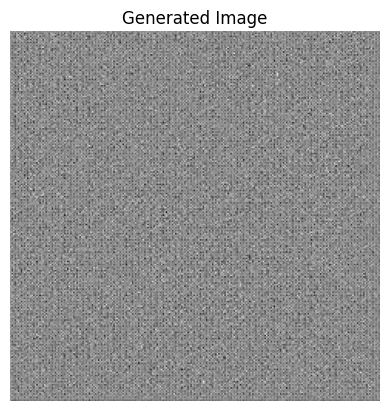

In [10]:
batch_size = 1
encoding_dims = 128

dummy_input = torch.randn(batch_size, 1, 240, 240)  # Shape: (batch_size, channels, height, width)

model = AAEGenerator(encoding_dims)

model.train()
generated_image, encoding = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Generated image shape: {generated_image.shape}")
print(f"Encoding vector shape: {encoding}")

model.eval()
generated_image = model(encoding)

print(f"Generated image shape: {generated_image.shape}")
print(f"Encoding vector shape: {encoding.shape}")

generated_image = generated_image.squeeze(0).detach().cpu().numpy() 
plt.imshow(generated_image[0], cmap='gray')  
plt.title('Generated Image')
plt.axis('off')
plt.show()

The loss function of the autoencoder consists of two terms:

* The reconstruction error: Mean squared error between the input image and the reconstruction.

* The negative log likelihood of the generated noise (encodings) w.r.t to the discriminator.

In [ ]:
class AAEGeneratorLoss:
    def __init__(self, reconstruction_weight = 1, adversarial_weight = 0.001): # varying adversarial_weight 
        super(AAEGeneratorLoss, self).__init__()
        self.reconstruction_weight = reconstruction_weight
        self.adversarial_weight = adversarial_weight
    
    def forward(self, real_ct_inputs, generated_output, dgz):
        reconstruction_loss = F.mse_loss(generated_output, real_ct_inputs) # or perceptual loss
        
        target = torch.ones_like(dgz, device=device) 
        adversarial_loss = F.binary_cross_entropy_with_logits(dgz, target) 
        
        total_loss = self.reconstruction_weight*reconstruction_loss + self.adversarial_weight*adversarial_loss
        return total_loss

    def train_ops(self, generator, discriminator, optimizer_generator, real_mr_inputs, real_ct_inputs):
        
        # Image and latent vector generated
        reconstructed, encodings = generator(real_mr_inputs)
        
        optimizer_generator.zero_grad()
        
        # Discriminator output from the encodings (latent vector)
        dgz = discriminator(encodings)
        
        # Compute generator loss
        loss = self.forward(real_ct_inputs, reconstructed, dgz)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer_generator.step()
        
        return loss.item(), encodings

In [12]:
class AAEDiscriminatorLoss:
    def __init__(self): 
        super(AAEDiscriminatorLoss, self).__init__()
    
    def forward(self, dx, dgz):
        
        target_real = torch.ones_like(dx) # target for real samples: p(z) -> latent vector from CT real scans
        target_fake = torch.zeros_like(dgz) # target for fake samples: q(z) -> latent vector from MRI input
        
        loss_real = F.binary_cross_entropy_with_logits(dx, target_real)
        loss_fake = F.binary_cross_entropy_with_logits(dgz, target_fake)
        
        total_loss = 0.5*(loss_fake+loss_real)
        return total_loss

    def train_ops(self, generator, discriminator, optimizer_discriminator, real_inputs_mri, real_ct):

        # Generate fake latent vectors (encoded inputs)
        _, encodings = generator(real_inputs_mri)
        
        #noise =  torch.randn(real_inputs_mri.size(0), generator.encoding_dims, device=device)
        real_ct = real_ct.to(device)
        
        optimizer_discriminator.zero_grad()
        
        real_ct_encoding = generator.encoder_part(real_ct) # vetor latente a partir do CT real
        
        # Discriminator output from the encodings (latent vector)
        dx = discriminator(real_ct_encoding) # output for real samples
        dgz = discriminator(encodings) # output for fake samples
        
        # Compute generator loss
        loss = self.forward(dx, dgz)
        
        # Backpropagation and update weights
        loss.backward()
        optimizer_discriminator.step()
        
        return loss.item()


In [15]:
generator = AAEGenerator(encoding_dims=512).to(device)
discriminator = Discriminator(input_dims=512).to(device)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


# number of epochs to train the model
n_epochs = 50

train_losses_d = []
train_losses_g = []
encodings = []

for epoch in range(1, n_epochs+1):
    generator.train()
    discriminator.train()
    
    # monitor training loss
    train_loss_d = 0.0
    train_loss_g = 0.0
    
    ###################
    # train the model #
    ###################
    for batch in train_dl:
        
        # Model inputs
        images_mri = batch["mr"].to(device)  # Shape: [B, C, H, W, D]
        images_ct = batch["ct"].to(device)  # Shape: [B, C, H, W, D]

        image_mri = images_mri[:,:,:,:,14] # 14 slice
        image_ct = images_ct[:,:,:,:,14] # 14 slice
        
        # Train the discriminator 
        discriminator_loss = AAEDiscriminatorLoss().train_ops(generator, discriminator, optimizer_discriminator, image_mri, image_ct)
        
        # Train the generator
        generator_loss, batch_encodings = AAEGeneratorLoss().train_ops(generator, discriminator, optimizer_generator, image_mri, image_ct)
        
        encodings.append(batch_encodings.detach().cpu())
        train_loss_d += discriminator_loss
        train_loss_g += generator_loss
            
    # print avg training metrics 
    avg_discriminator_loss = train_loss_d/len(train_dl)
    avg_generator_loss = train_loss_g/len(train_dl)
    
    
    print('Epoch: {} \tTraining Discriminator Loss: {:.6f} \tTraining Generator Loss: {:.6f}'.format(
        epoch, 
        avg_discriminator_loss,
        avg_generator_loss
        ))
    
    train_losses_d.append(avg_discriminator_loss)
    train_losses_g.append(avg_generator_loss)


Epoch: 1 	Training Discriminator Loss: 0.675505 	Training Generator Loss: 0.903304
Epoch: 2 	Training Discriminator Loss: 0.698282 	Training Generator Loss: 0.837584
Epoch: 3 	Training Discriminator Loss: 0.688297 	Training Generator Loss: 0.737216
Epoch: 4 	Training Discriminator Loss: 0.675672 	Training Generator Loss: 0.745463
Epoch: 5 	Training Discriminator Loss: 0.684523 	Training Generator Loss: 0.828237
Epoch: 6 	Training Discriminator Loss: 0.687361 	Training Generator Loss: 0.614931
Epoch: 7 	Training Discriminator Loss: 0.694010 	Training Generator Loss: 0.628285
Epoch: 8 	Training Discriminator Loss: 0.689243 	Training Generator Loss: 0.587904
Epoch: 9 	Training Discriminator Loss: 0.690077 	Training Generator Loss: 0.635161
Epoch: 10 	Training Discriminator Loss: 0.682699 	Training Generator Loss: 0.605382
Epoch: 11 	Training Discriminator Loss: 0.683830 	Training Generator Loss: 0.605933
Epoch: 12 	Training Discriminator Loss: 0.676491 	Training Generator Loss: 0.615793
E

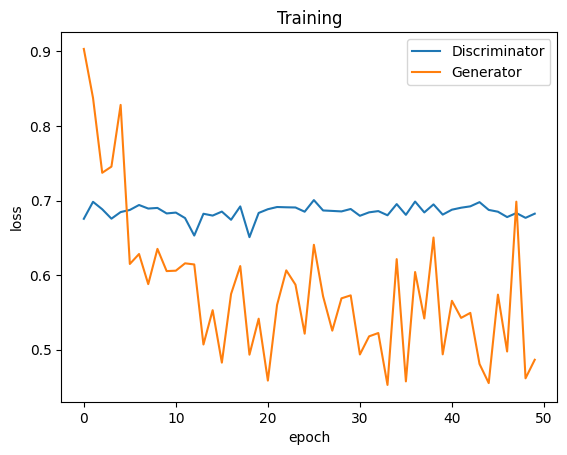

In [16]:
plt.plot(train_losses_d, '-')
plt.plot(train_losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Training');